In [1]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import nolearn
from nolearn.lasagne import NeuralNet
import readdata
import lasagne
from lasagne import layers
from sklearn import metrics
import detectobjects as det
import os.path
from scipy import misc
import cv2
from progress_bar import ProgressBar
import shapefeatures
from sklearn import ensemble

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
opts = {'img_dir': '../Annotationxml/',
        'annotation_dir': '../Annotationxml/',
        'detection_probability_threshold': 0.5,
        'detection_overlap_threshold': 0.3, 
        'gauss': 1,
        'patch_size': (50,50),
        'image_downsample' : 2,
        'detection_step': 5,
        'patch_creation_step': 40,
        'object_class': None,
        'negative_training_discard_rate': .9
       }
opts['patch_stride_training'] = int(opts['patch_size'][0]*.25)

In [3]:
trainfiles, valfiles, testfiles = readdata.create_sets(opts['img_dir'], train_set_proportion=.5, 
                                                  test_set_proportion=.5,
                                                  val_set_proportion=0)

train_y, train_X = readdata.create_patches(trainfiles, opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])
test_y, test_X = readdata.create_patches(testfiles,  opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])

# Cut down on disproportionately large numbers of negative patches
train_X, train_y = readdata.balance(train_X, train_y, mult_neg=100)
#test_X, test_y = readdata.balance(test_X, test_y, mult_neg=100)

# Create rotated and flipped versions of the positive patches
train_X, train_y = readdata.augment_positives(train_X, train_y)
test_X, test_y = readdata.augment_positives(test_X, test_y)

print '\n'
print '%d positive training examples, %d negative training examples' % (sum(train_y), len(train_y)-sum(train_y))
print '%d positive testing examples, %d negative testing examples' % (sum(test_y), len(test_y)-sum(test_y))
print '%d patches (%.1f%% positive)' % (len(train_y)+len(test_y), 100.*((sum(train_y)+sum(test_y))/(len(train_y)+len(test_y))))

[****************100%******************]  271 of 271 complete                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

12016 positive training examples, 121310 negative training examples
11352 positive testing examples, 122612 negative testing examples
267290 patches (8.7% positive)


In [4]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['patch_size'][0]/opts['image_downsample'], 
                 opts['patch_size'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(5, 5), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters=12, 
    conv2_filter_size=(2, 2),    
    conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    hidden3_num_units=500,
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(0).fit(train_X, train_y)

# Neural Network with 488382 learnable parameters

## Layer information

  #  name     size
---  -------  -------
  0  input    3x25x25
  1  conv1    7x21x21
  2  pool1    7x10x10
  3  conv2    12x9x9
  4  hidden3  500
  5  output   2



In [52]:
cnn.load_weights_from('whiteflyweights')

Loaded parameters to layer 'conv1' (shape 7x3x5x5).
Loaded parameters to layer 'conv1' (shape 7).
Loaded parameters to layer 'conv2' (shape 12x7x2x2).
Loaded parameters to layer 'conv2' (shape 12).
Loaded parameters to layer 'hidden3' (shape 972x500).
Loaded parameters to layer 'hidden3' (shape 500).
Loaded parameters to layer 'output' (shape 500x2).
Loaded parameters to layer 'output' (shape 2).


In [7]:
y_pred = cnn.predict_proba(test_X)

/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):


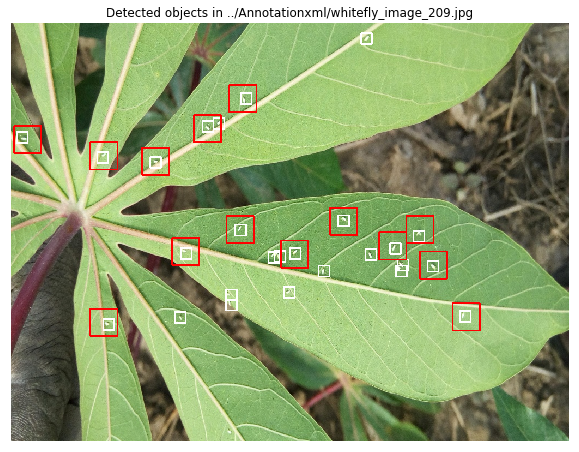

In [56]:
reload(det)

fname = testfiles[14]
imfile = opts['img_dir'] + fname
opts['detection_probability_threshold'] = 0.5
opts['detection_overlap_threshold'] = 0.1
found = det.detect(imfile, cnn, opts)

im = misc.imread(imfile)

plt.box(False)
plt.xticks([])
plt.yticks([])

annofile = opts['annotation_dir'] + fname[:-3] + 'xml'
bboxes = readdata.get_bounding_boxes_for_single_image(annofile)
for bb in bboxes:
    bb = bb.astype(int)
    cv2.rectangle(im, (bb[0],bb[2]), (bb[1],bb[3]), (255,255,255), 2)  

for f in found:
    f = f.astype(int)
    cv2.rectangle(im, (f[0],f[1]), (f[2],f[3]), (255,0,0), 2)

plt.gcf().set_size_inches(10,10)
plt.title('Detected objects in %s' % (imfile))
plt.imshow(im)

#cv2.imwrite('detectionimages/detected-' + os.path.basename(imfile),im)